In [117]:
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
import torchtext
import torch.nn as nn
import nltk
import pandas as pd
nltk.download('punkt')
cmap = plt.get_cmap('viridis')
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [118]:
import os
rootdir = '/home/stephane/automatic-data-generation/'
dataroot= rootdir + 'data/'
os.chdir(rootdir)

save_dir = 'fig/'

# Analyzing the runs

In [119]:
def anneal_fn(anneal_function, step, k, x, m):
    if anneal_function == 'logistic':
        return m*float(1/(1+np.exp(-k*(step-x))))
    elif anneal_function == 'linear':
        return m*min(1, step/x)
anneal_fn = np.vectorize(anneal_fn)

In [153]:
import torch
run = torch.load('run.pkl')

## Dynamics

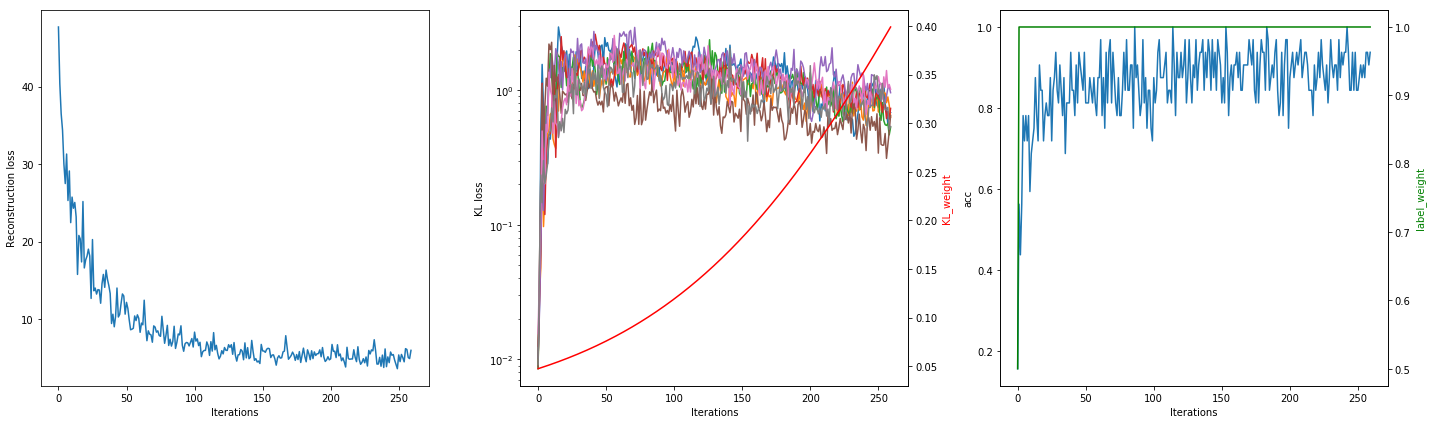

In [83]:
fig, axarr = plt.subplots(1,3, figsize=(20,6))
axarr = axarr.flatten()

args = run['args']
NLL_hist = run['logs']['train']['recon_loss']
KL_hist  = run['logs']['train']['kl_losses' ]
acc_hist = run['logs']['train']['conditioning_accuracy']
t = np.array(range(len(NLL_hist)))

KL_weight    = anneal_fn(args['annealing_strategy'], t, args['kl_anneal_rate'], args['kl_anneal_time'], args['kl_anneal_target'])
label_weight = anneal_fn(args['annealing_strategy'], t, args['label_anneal_rate'], args['label_anneal_time'], args['label_anneal_target'])

axarr[0].plot(t, NLL_hist )

KL_hist = np.array(KL_hist)
for i in range(args['latent_size']):
    axarr[1].semilogy(t, KL_hist[i], label=i)
ax1bis = axarr[1].twinx()
ax1bis.plot(t, KL_weight, color='red')

axarr[2].plot(t, acc_hist )
ax2bis = axarr[2].twinx()
ax2bis.plot(t, label_weight, color='green')

for i in range(3):
    axarr[i].set_xlabel('Iterations')
axarr[0].set_ylabel('Reconstruction loss')
axarr[1].set_ylabel('KL loss')
ax1bis.set_ylabel('KL_weight', color='red')
axarr[2].set_ylabel('acc')
ax2bis.set_ylabel('label_weight', color='green')

#fig.legend()
fig.tight_layout()
plt.show()

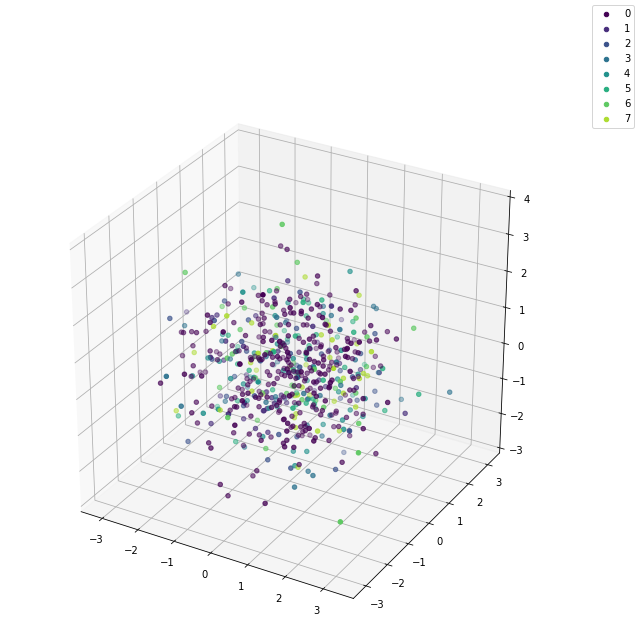

In [70]:
n_per_intent = 2000

latent = run['latent_rep']
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
all_latent = sum([latent_list for latent_list in latent.values()], [])
pca.fit(all_latent)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for intent in latent.keys():
    points = pca.transform(latent[intent])
    #points = np.array(latent[intent])
    ax.scatter(points[:n_per_intent,0], points[:n_per_intent,1], points[:n_per_intent,2], c=[cmap(intent/len(latent.keys()))], label='{}'.format(intent))
fig.legend()
plt.show()

## Embeddings

python -m grid results_embedding "python automatic_data_generation/train_and_eval_cvae.py -ng 2000 -ep 50" --dataset-size 200 --slot-embedding:str no_slot_embedding litteral micro --embedding-type:str glove random --embedding-dimension 100 200 300 --seed 1 2 3 --n_parallel 8

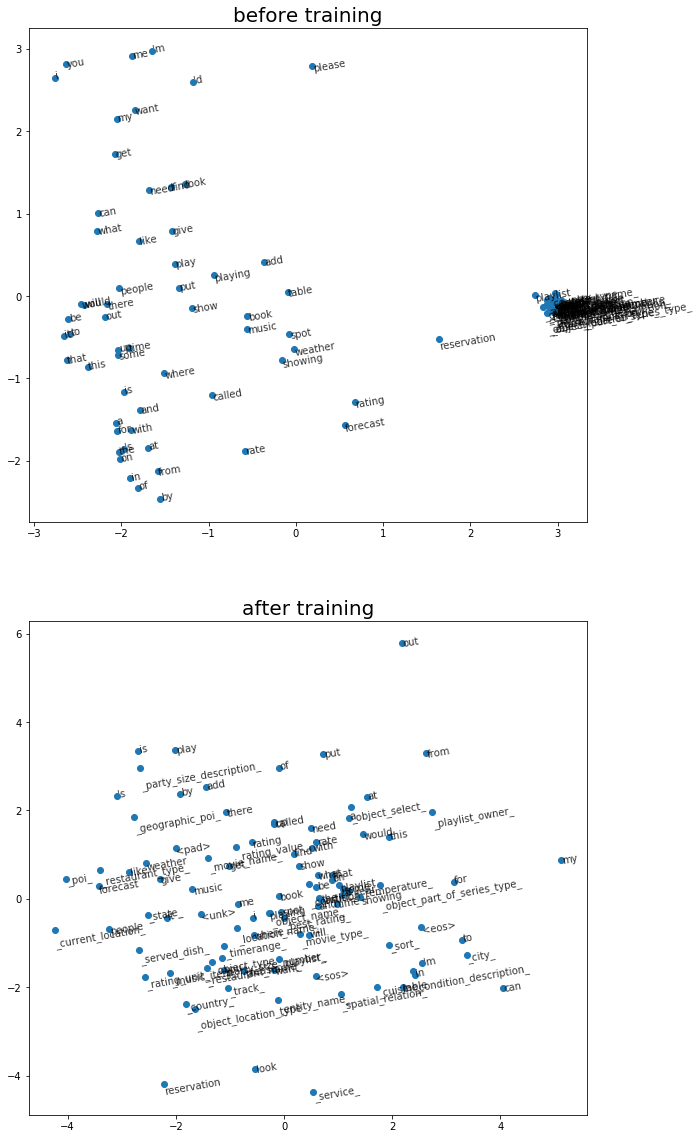

In [20]:
n_start = 0
n_end = 100
words = run['i2w']

fig, axarr = plt.subplots(2, 1, figsize=(10,20))
axarr = axarr.flatten()

from sklearn.decomposition import PCA
for ax, stage in enumerate(['before', 'after']):
    vectors = run['vectors'][stage]
    pca = PCA(n_components=2)
    proj = pca.fit_transform(vectors.cpu())
    axarr[ax].scatter(proj[n_start:n_end,0], proj[n_start:n_end,1])
    for i, word in enumerate(words[n_start:n_end]):
        i += n_start
        axarr[ax].annotate(word,xy=(proj[i,0], proj[i,1]), rotation=10, alpha=0.8)
    axarr[ax].set_title('%s training'%stage, fontsize=20)

## Trajectories in latent space

In [82]:
from models.embedding import Datasets
from models.cvae import CVAE
from utils.utils import to_device, interpolate, idx2word

run = torch.load('run.pkl')
args = run['args']

datadir = os.path.join('./data', args.dataset)
train_path = os.path.join(datadir, 'train.csv')
validate_path = os.path.join(datadir, 'validate.csv')
datasets = Datasets(train_path=os.path.join(train_path), valid_path=os.path.join(validate_path), emb_dim=args.emb_dim, tokenizer=args.tokenizer)

if args.input_type=='delexicalised':
    print('embedding the slots with %s averaging' %args.slot_averaging)
    datasets.embed_slots(args.slot_averaging)

vocab = datasets.TEXT.vocab if args.input_type=='utterance' else datasets.DELEX.vocab
i2w = vocab.itos
w2i = vocab.stoi
i2int = datasets.INTENT.vocab.itos
int2i = datasets.INTENT.vocab.stoi
n_classes = len(i2int)
sos_idx = w2i['<sos>']
eos_idx = w2i['<eos>']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

model = CVAE(
        vocab_size=len(i2w),
        max_sequence_length=args.max_sequence_length,
        sos_idx=sos_idx,
        eos_idx=eos_idx,
        pad_idx=pad_idx,
        unk_idx=unk_idx,
        embedding_size=args.emb_dim,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        z_size=args.latent_size,
        n_classes=n_classes,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional,
        temperature=args.temperature,
        conditional=False if args.conditional=='none' else True,
        bow=args.bow_loss
    )

state_dict = torch.load(args.pickle+'.pyT')
if state_dict['embedding.weight'].size(0) != model.embedding.weight.size(0): # vocab changed
    state_dict['embedding.weight'] = vocab.vectors
    state_dict['outputs2vocab.weight'] = torch.randn(len(i2w), args.hidden_size*model.hidden_factor)
    state_dict['outputs2vocab.bias'] = torch.randn(len(i2w))
model.load_state_dict(state_dict)

print('BLEU : ',run['bleu_scores'])
print('Diversity : ',run['diversity'])

ModuleNotFoundError: No module named 'models.embedding'

In [63]:
i2int

['GetWeather',
 'PlayMusic',
 'BookRestaurant',
 'SearchScreeningEvent',
 'RateBook',
 'SearchCreativeWork',
 'AddToPlaylist']

### Vary the continuous variable

In [ ]:
for i, intent in enumerate(i2int):
    
    interp_dim = 1
    print(intent)

    #z1 = torch.randn([args.latent_size]).numpy()
    #z2 = torch.randn([args.latent_size]).numpy()
    z1 = torch.zeros([args.latent_size]).numpy()
    z2 = torch.zeros([args.latent_size]).numpy()
    z1[interp_dim] = -5
    z2[interp_dim] = +5
    z = to_device(torch.from_numpy(interpolate(start=z1, end=z2, steps=10)).float())
    batch_size=z.size(0)

    y_onehot = torch.zeros(batch_size, model.n_classes)
    y = torch.LongTensor(batch_size,1).fill_(i)
    y_onehot.scatter_(1, y, 1)
    samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

    print('-------INTERPOLATIONS-------')
    print(*idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>']), sep='\n')
    print('\n')

### Vary the discrete variable

z = torch.randn(model.n_classes,args.latent_size)

y_onehot = torch.zeros(model.n_classes, model.n_classes)
for i in range(model.n_classes):
    y_onehot[i,i] = 1

samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

for intent, sentence in enumerate(idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>'])):
    print(i2int[intent])
    print(sentence + '\n')

## Generated sentences

In [71]:
def get_trainset(dataset):

    import torchtext
    from nltk import word_tokenize
    train_path = 'data/{}/train.csv'.format(dataset)
    valid_path = 'data/{}/validate.csv'.format(dataset)

    TEXT = torchtext.data.Field(lower=True, tokenize=word_tokenize,
                                sequential=True, batch_first=True,
                                include_lengths=True,
                                init_token='<sos>', eos_token='<eos>')
    LABEL = torchtext.data.Field(lower=False, tokenize=word_tokenize,
                                sequential=True, batch_first=True,
                                include_lengths=True,
                                init_token='<sos>', eos_token='<eos>')
    DELEX = torchtext.data.Field(lower=True, tokenize=word_tokenize,
                                 sequential=True, batch_first=True,
                                 include_lengths=True,
                                 init_token='<sos>', eos_token='<eos>')
    INTENT = torchtext.data.Field(sequential=False, batch_first=True,
                                  unk_token=None, pad_token=None)

    skip_header = True
    if 'snips' in train_path:
        datafields = [("utterance", TEXT), ("labels", LABEL),
                      ("delexicalised", DELEX), ("intent", INTENT)]

    train, valid = torchtext.data.TabularDataset.splits(
        path='.',  # the root directory where the data lies
        train=train_path,
        validation=valid_path,
        format='csv',
        skip_header=skip_header,
        # if your csv header has a header, make sure to pass this to
        # ensure it doesn't get proceesed as data!
        fields=datafields
    )

    TEXT.build_vocab(train)
    LABEL.build_vocab(train)
    INTENT.build_vocab(train)

    return train

In [72]:
import operator

#run = torch.load('without_none.pkl')
#run = runs[-2]
#print(run['delexicalised_metrics']['intent_accuracy'])

dic_gen = {intent:{} for intent in run['i2int']}
for i, delex in enumerate(run['generated']['delexicalised']):
    intent = run['generated']['intents'][i]
    if delex not in dic_gen[intent]:
        dic_gen[intent][delex] = 1
    else:
        dic_gen[intent][delex] += 1
        
train = get_trainset('snips')
        
dic_tr = {intent:{} for intent in run['i2int']}
for i, example in enumerate(train):
    intent = example.intent
    delex = ' '.join(example.delexicalised)
    if delex not in dic_tr[intent].keys():
        dic_tr[intent][delex] = 1
    else:
        dic_tr[intent][delex] += 1   
        
for dic in [dic_gen]:
    for intent in run['i2int']:
        dic[intent] = sorted(dic[intent].items(), key=operator.itemgetter(1))[::-1]

In [74]:
intent = 'GetWeather'

print('{:<12} {:<12} {}\n'.format('# generated', '# trainset', 'sentence'))
for sentence, gen_occurences in dic_gen[intent]:
    tr_occurences = dic_tr[intent][sentence] if sentence in dic_tr[intent] else 0
    print('{:<12} {:<12} {}'.format(gen_occurences, tr_occurences, sentence))

print('\n')
for dic in [dic_tr]:
    for key, val in dic[intent].items():
        pass
        #print('{:<6} {}'.format(val, key))

# generated  # trainset   sentence

6            0            will it be _forecast_condition_name_ on _forecast_geographical_poi_ _forecast_start_datetime_
6            0            what 's the weather in _forecast_country_ going to be like _forecast_start_datetime_
3            0            will it be _forecast_condition_name_ in _forecast_region_ _forecast_start_datetime_
2            0            will there be _forecast_condition_name_ at _forecast_region_ _forecast_start_datetime_
2            4            what 's the weather forecast for _city_ _state_
2            17           what 's the weather in _city_
2            1            will there be any _condition_description_ in _state_ on _timerange_
2            0            is it going to be _forecast_condition_name_ in _forecast_geographical_poi_ _forecast_start_datetime_
2            0            is it going to be _forecast_condition_name_ in _forecast_country_ _forecast_start_datetime_
1            0            is it going to 

## Per intent metrics

error
error
error
error


ValueError: could not broadcast input array from shape (7) into shape (4)

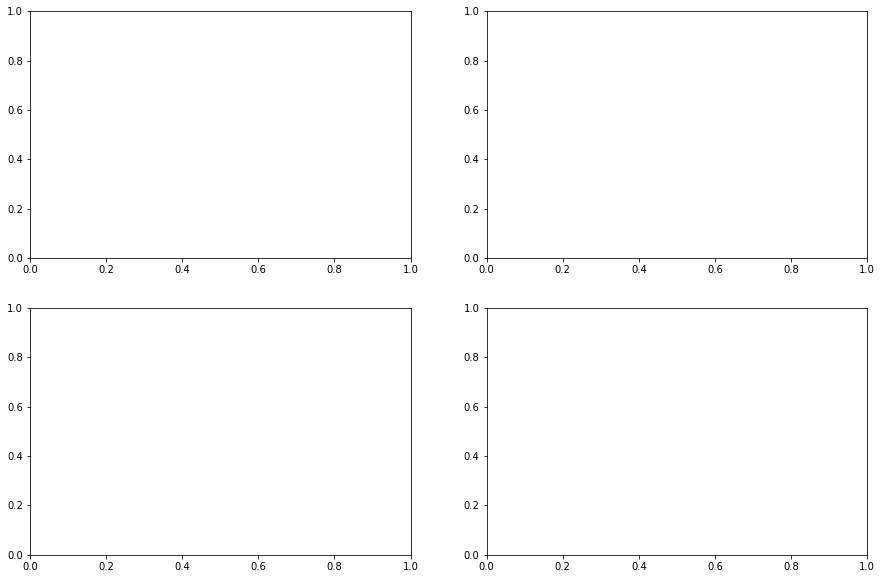

In [108]:
fig, axarr = plt.subplots(2,2, figsize=(15,10))
axarr = axarr.flatten()
    
for irun, run in enumerate([run]):

    try:
        run['i2int'].remove('None')
    except:
        print('error')

    
    bleu_qualities     = [run['delexicalised_metrics']['bleu_scores']['quality'][intent]   for intent in i2int]
    bleu_diversities   = [run['delexicalised_metrics']['bleu_scores']['diversity'][intent] for intent in i2int]
    originalities      = [run['delexicalised_metrics']['originality'][intent]              for intent in i2int]
    transfer           = [run['delexicalised_metrics']['transfer']['metric'][intent]       for intent in i2int]
    accuracies         = [run['delexicalised_metrics']['intent_accuracy'][intent]          for intent in i2int]
    metrics = [bleu_qualities, accuracies, originalities, bleu_diversities]
    
    for i, metric in enumerate(metrics):
    
        axarr[i].bar([intent.split(':')[-1] for intent in run['i2int']], 
                     metric, label=run['args']['pickle'].split('/')[-1] if i==0 else '',
                    alpha = 0.2, color = cmap(irun/len(runs)))
        for label in axarr[i].get_xmajorticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment("right")
        low, high, delta = min(metric), max(metric), max(metric) - min(metric)
        #axarr[i].set_ylim(low - 0.2 * delta, high + 0.2 * delta)
        axarr[i].set_xlabel('Class')

axarr[0].set_ylabel('BLEU quality'  )
axarr[1].set_ylabel('Accuracy'      )
axarr[2].set_ylabel('Originality'   )
axarr[3].set_ylabel('Bleu diversity')

fig.suptitle('Queries: {}'.format(run['args']['dataset_size']), fontsize=20)
fig.legend(loc='center')

fig.tight_layout(rect=[0, 0.03, 1, 0.9])

## Categorical variable

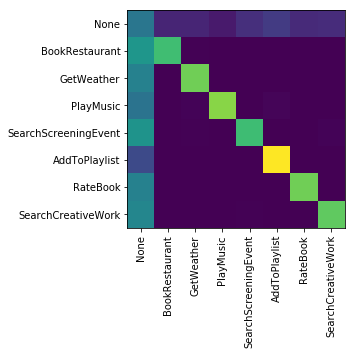

In [154]:
data = run['logs']['dev']['classifications']
classifications = np.zeros((len(data), len(data)))
for i1, intent1 in enumerate(data.keys()):
    for i2, intent2 in enumerate(data[intent1].keys()):
        classifications[i1][i2] = data[intent1][intent2]/sum(data[intent1].values())
#classifications[0][1]=1000
plt.imshow(classifications)

labels = data.keys()
plt.gca().set_xticks(range(len(labels)))
plt.gca().set_yticks(range(len(labels)))
plt.gca().set_xticklabels(labels, rotation=90)
plt.gca().set_yticklabels(labels)
plt.show()

{'None': tensor([ -691616.0625, -2393526.0000, -2189035.5000, -2202748.5000,
        -2060326.7500, -2229896.0000, -2243646.2500, -2443417.7500]), 'BookRestaurant': tensor([ -341746.3750,  -961712.1250,  -998680.8125, -1288641.1250,
        -1185298.2500,  -972464.5625, -1289881.2500, -1370995.2500]), 'GetWeather': tensor([ -355073.0000, -1143627.7500,  -938353.8125, -1239935.5000,
        -1184007.2500, -1113377.6250, -1257347.5000, -1203964.5000]), 'PlayMusic': tensor([ -366696.1875, -1393028.5000, -1263462.7500,  -793237.7500,
        -1243909.8750, -1176409.1250,  -913765.6875, -1191963.7500]), 'SearchScreeningEvent': tensor([ -378413.8438, -1253294.8750, -1090634.6250, -1201701.7500,
         -816651.3750, -1098528.3750, -1196157.7500, -1227595.6250]), 'AddToPlaylist': tensor([ -391034.3438, -1135348.0000, -1072843.3750, -1270179.3750,
        -1204585.2500,  -745043.0000, -1327915.5000, -1429157.7500]), 'RateBook': tensor([ -339025.5625, -1440395.5000, -1303709.8750,  -960482.562

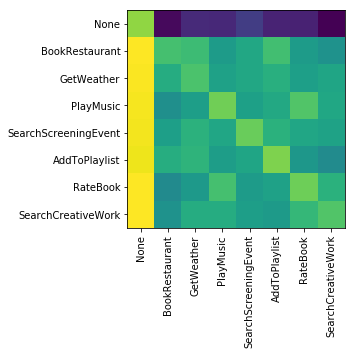

In [155]:
data = run['logs']['dev']['transfer']
print(data)
transfer = np.zeros((len(data), len(list(data.values())[0])))
for i1, intent1 in enumerate(data.keys()):
    transfer[i1] = data[intent1]
plt.imshow(transfer)

labels = data.keys()
plt.gca().set_xticks(range(len(labels)))
plt.gca().set_yticks(range(len(labels)))
plt.gca().set_xticklabels(labels, rotation=90)
plt.gca().set_yticklabels(labels)
plt.show()

In [116]:
a = []
a+=[[1,2,3]]
a+=[[1,2,3]]
a

[[1, 2, 3], [1, 2, 3]]

# Demo

In [508]:
def demo():
    
    run = torch.load('run.pkl')

    requested_intent = input('Select your intent : ')
    print('\n')
    indices = [i for i,intent in enumerate(run['generated']['intents']) if intent == requested_intent]

    print(*[run['generated']['utterances'][idx] for idx in indices], sep='\n\n')

# Effect of dataset size

In [ ]:
datasizes        = [run['args'].datasize for run in runs]
bleu_qualities   = [run['metrics']['bleu_scores']['quality']['avg'] for run in runs]
bleu_diversities = [run['metrics']['bleu_scores']['diversity']['avg'] for run in runs]
org_bleu_diversities = [run['metrics']['bleu_scores']['original_diversity']['avg'] for run in runs]
diversities      = [run['metrics']['diversity'] for run in runs]
entropies     = [run['metrics']['entropy'] for run in runs]
accuracies       = [run['metrics']['intent_accuracy'] for run in runs]
raw          = [run['metrics']['improvement']['raw_acc'] for run in runs]
augmented    = [run['metrics']['improvement']['aug_acc'] for run in runs]
se_augmented = [run['slot_expansion_metrics']['improvement']['aug_acc'] for run in runs]

delex_bleu_qualities   = [run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs]
delex_bleu_diversities = [run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs]
org_delex_bleu_diversities = [run['metrics']['bleu_scores']['original_diversity']['avg'] for run in runs]
delex_diversities      = [run['delexicalised_metrics']['diversity'] for run in runs]
delex_accuracies       = [run['delexicalised_metrics']['intent_accuracy'] for run in runs]

se_bleu_qualities   = [run['slot_expansion_metrics']['bleu_scores']['quality']['avg'] for run in runs]
se_bleu_diversities = [run['slot_expansion_metrics']['bleu_scores']['diversity']['avg'] for run in runs]
se_diversities      = [run['slot_expansion_metrics']['diversity'] for run in runs]
se_accuracies       = [run['slot_expansion_metrics']['intent_accuracy'] for run in runs]

fig, axarr = plt.subplots(2,3, figsize=(14,7))
axarr = axarr.flatten()

axarr[0].scatter(datasizes, augmented, label='Augmented'                ,alpha=0.5)
axarr[0].scatter(datasizes, se_augmented, label='Slot Expansion'        ,alpha=0.5)
axarr[0].scatter(datasizes, raw, label='Raw'                            ,alpha=0.5)
axarr[1].scatter(datasizes, bleu_qualities     ,label='Augmented'     ,alpha=0.5)
axarr[1].scatter(datasizes, se_bleu_qualities  ,label='Slot Expansion'  ,alpha=0.5)
axarr[1].scatter(datasizes, delex_bleu_qualities  ,label='Delexicalised',alpha=0.5)
axarr[2].scatter(datasizes, accuracies         ,label='Augmented'     ,alpha=0.5)
axarr[2].scatter(datasizes, se_accuracies      ,label='Slot Expansion'  ,alpha=0.5)
axarr[2].scatter(datasizes, delex_accuracies      ,label='Delexicalised',alpha=0.5)
#axarr[3].scatter(datasizes, org_bleu_diversities,label='Original',alpha=0.5)
#axarr[3].scatter(datasizes, bleu_diversities   ,label='Augmented'     ,alpha=0.5)
#axarr[3].scatter(datasizes, se_bleu_diversities,label='Slot Expansion'  ,alpha=0.5)
axarr[3].scatter(datasizes, delex_bleu_diversities,label='Delexicalised',alpha=0.5)
axarr[3].scatter(datasizes, org_delex_bleu_diversities,label='Original delexicalised',alpha=0.5)
axarr[4].scatter(datasizes, diversities        ,label='Augmented'     ,alpha=0.5)
axarr[4].scatter(datasizes, se_diversities     ,label='Slot Expansion'  ,alpha=0.5)
axarr[4].scatter(datasizes, delex_diversities     ,label='Delexicalised',alpha=0.5)
axarr[5].scatter(datasizes, entropies                                   )

axarr[0].set_ylabel('Intent classif improvement ')
axarr[1].set_ylabel('BLEU quality')
axarr[2].set_ylabel('Intent accuracy')
axarr[3].set_ylabel('BLEU diversity')
axarr[4].set_ylabel('Diversity')
axarr[5].set_ylabel('Entropy')
for ax in axarr:
    ax.set_xscale('log')
    ax.set_xlabel('Train data size')
    ax.legend()

fig.tight_layout()

# Transfer from a None class

python -m grid results_transfer "python automatic_data_generation/train_and_eval_cvae.py -ep 50 --dataset-size 70 --none-type yelp" --none-size:int 0 10 20 50 100 200 500 1000 --n_parallel 1

In [188]:
#results_dir = 'results_datasize_prop'
results_dir = '../results_transfer'
runs = []

for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        runs.append(torch.load(os.path.join(results_dir,filename)))
        
runs.sort(key = lambda x : x['args']['none_size'])
runs.sort(key = lambda x : x['args']['none_type'])
#runs.sort(key = lambda x : x['args']['none_size'])

data = {}
for arg_name in runs[0]['args'].keys():
    try:
        data[arg_name] = [run['args'][arg_name] for run in runs]
    except:
        pass
data['bleu_quality']   = np.array([run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs])
data['bleu_diversity'] = np.array([run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs])
data['accuracy']       = np.array([run['delexicalised_metrics']['intent_accuracy'] for run in runs])

    
df = pd.DataFrame(data, columns=['dataset_size', 'n_epochs', 'none_size', 'none_type', 'accuracy'])
df.head(30)

,dataset_size,n_epochs,none_size,none_type,accuracy
0,70,50,0,snips-assistant,0.788000
1,70,50,10,snips-assistant,0.780822
2,70,50,20,snips-assistant,0.695556
3,70,50,50,snips-assistant,0.744344
4,70,50,100,snips-assistant,0.814480
5,70,50,200,snips-assistant,0.888383
6,70,50,500,snips-assistant,0.917995
7,70,50,0,subtitles,0.474000
8,70,50,10,subtitles,0.402746
9,70,50,20,subtitles,0.451542


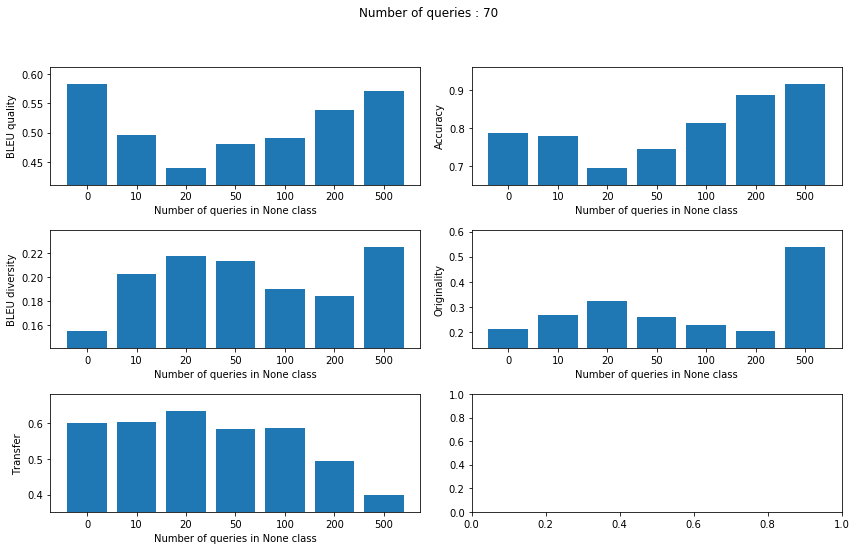

In [189]:
runs = [run for run in runs if (run['args']['none_type']=='snips-assistant') and (run['args']['dataset_size']==70)]


none_sizes = [str(run['args']['none_size']) for run in runs]

intents = runs[0]['delexicalised_metrics']['bleu_scores']['quality'].keys()

#bleu_qualities     = [np.mean([    run['delexicalised_metrics']['bleu_scores']['quality'][intent] for intent in intents if intent!='None']) for run in runs]
bleu_qualities     = [run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs]
accuracies         = [run['delexicalised_metrics']['intent_accuracy'] for run in runs]
bleu_diversities   = [run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs]
bleu_originalities = [run['delexicalised_metrics']['originality']['avg'] for run in runs]
transfer           = [run['delexicalised_metrics']['transfer']['avg'] for run in runs]
metrics = [bleu_qualities, accuracies, bleu_diversities, bleu_originalities, transfer]

accuracies
fig, axarr = plt.subplots(3,2, figsize=(12,8))
axarr = axarr.flatten()

for i, metric in enumerate(metrics):

    axarr[i].bar(none_sizes, metric )
    low, high, delta = min(metric), max(metric), max(metric) - min(metric)
    axarr[i].set_ylim(low - 0.2 * delta, high + 0.2 * delta)
    axarr[i].set_xlabel('Number of queries in None class')

axarr[0].set_ylabel('BLEU quality'  )
axarr[1].set_ylabel('Accuracy'      )
axarr[2].set_ylabel('BLEU diversity')
axarr[3].set_ylabel('Originality'   )
axarr[4].set_ylabel('Transfer'   )

fig.suptitle('Number of queries : {}'.format(runs[0]['args']['dataset_size'], fontsize=20))

fig.tight_layout(rect=[0, 0.03, 1, 0.9])

In [178]:
run = runs[-1]
requested_intent = 'PlayMusic'
indices = [i for i,intent in enumerate(run['generated']['intents']) if intent == requested_intent]
print(*[run['generated']['delexicalised'][idx] for idx in indices], sep='\n\n')

open _service_ and play the _sort_ songs from _artist_

_service_ _service_ to listen to deserve

play _service_ by _year_

_service_ _service_ left me listen to music released

play me the _genre_ _service_

open _service_ and play _track_ from _artist_

wish to music from the year _year_

open _service_ and play _track_ from _artist_

open _service_ and play _track_ from _artist_

open _service_ and play _track_ from _artist_

wish to hear music from play _track_ from the year _year_

play _artist_

open _service_ and play _track_ from _artist_

open _service_ and play the _sort_ songs from _artist_

does _service_ have music to play _track_

open _service_ to the _sort_ songs from the year _year_

play me a _music_item_ by _artist_

open _service_ and play the _sort_ songs from _artist_

open _service_ and play the _sort_ songs from _artist_

open _service_ and play _track_ by _artist_

wish to _music_item_ music _sort_ first in glasgow

does _service_ have music released by _artist

# One vs all

python -m grid results_onevsall_140 "python automatic_data_generation/train_and_eval_cvae.py -ep 100 --dataset-size 20 --n-generated 1000" --restrict-to-intent:str PlayMusic GetWeather RateBook BookRestaurant AddToPlaylist SearchScreeningEvent SearchCreativeWork None --n_parallel 1

In [82]:
results_dir = 'results_onevsall_140'
runs = []

for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        runs.append(torch.load(os.path.join(results_dir,filename)))
    
data = {}
for arg_name in runs[0]['args'].keys():
    data[arg_name] = [run['args'][arg_name] for run in runs]

vae_runs = [run for run in runs if run['args']['restrict_intent'] is not None]
cvae_run = [run for run in runs if run['args']['restrict_intent'] is None][0]
    
df = pd.DataFrame(data, columns=['pickle', 'dataset_size', 'n_generated', 'n_epochs', 'restrict_intent'])
df.head(20)

,pickle,dataset_size,n_generated,n_epochs,restrict_intent
0,results_onevsall_140/32815.pkl,20,1000,100,[SearchScreeningEvent]
1,results_onevsall_140/15295.pkl,20,1000,100,[BookRestaurant]
2,results_onevsall_140/10145.pkl,20,1000,100,[RateBook]
3,results_onevsall_140/05930.pkl,20,1000,100,[PlayMusic]
4,results_onevsall_140/32396.pkl,20,1000,100,[GetWeather]
5,results_onevsall_140/00000,140,1000,100,None
6,results_onevsall_140/08263.pkl,20,1000,100,[AddToPlaylist]
7,results_onevsall_140/35426.pkl,20,1000,100,[SearchCreativeWork]


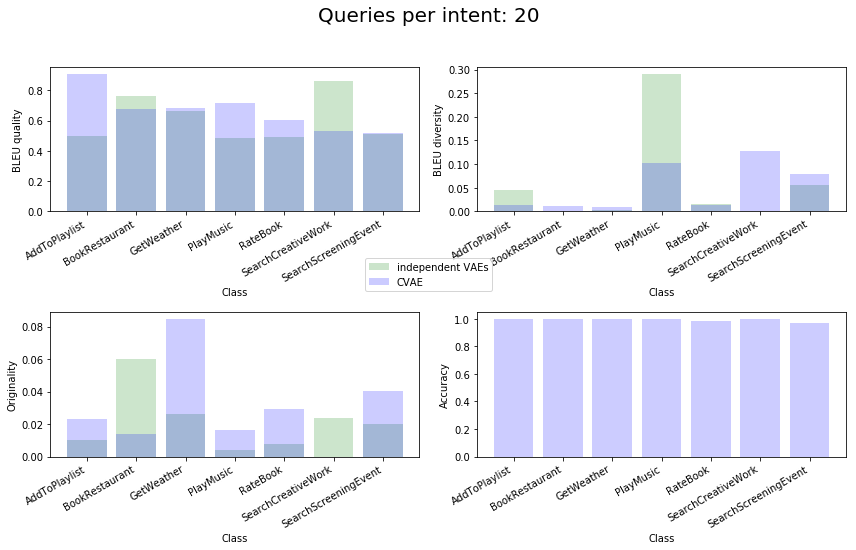

In [83]:
fig, axarr = plt.subplots(2,2, figsize=(12,8))
axarr = axarr.flatten()

restrict = sorted([str(run['args']['restrict_intent'][0]) for run in vae_runs])

bleu_qualities     = [run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in vae_runs]
bleu_diversities   = [run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in vae_runs]
originalities      = [run['delexicalised_metrics']['originality']['avg'] for run in vae_runs]
#transfer           = [run['delexicalised_metrics']['transfer']['avg'] for run in runs]
metrics = [bleu_qualities, bleu_diversities, originalities]

for i, metric in enumerate(metrics):
    axarr[i].bar(restrict, metric, alpha=0.2, color='green', label='independent VAEs' if i==0 else '')
    for label in axarr[i].get_xmajorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")
    low, high, delta = min(metric), max(metric), max(metric) - min(metric)
    #axarr[i].set_ylim(low - 0.2 * delta, high + 0.2 * delta)
    axarr[i].set_xlabel('Class')

bleu_qualities     = [cvae_run['delexicalised_metrics']['bleu_scores']['quality'][intent] for intent in restrict]
bleu_diversities   = [cvae_run['delexicalised_metrics']['bleu_scores']['diversity'][intent] for intent in restrict]
originalities      = [cvae_run['delexicalised_metrics']['originality'][intent] for intent in restrict]
accuracies         = [cvae_run['delexicalised_metrics']['intent_accuracy'][intent] for intent in restrict]
transfer           = [cvae_run['delexicalised_metrics']['transfer']['metric'][intent] for intent in restrict]
metrics = [bleu_qualities, bleu_diversities, originalities, accuracies]

for i, metric in enumerate(metrics):

    axarr[i].bar(restrict, metric, alpha=0.2, color='blue', label='CVAE' if i==0 else '')
    for label in axarr[i].get_xmajorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")
    low, high, delta = min(metric), max(metric), max(metric) - min(metric)
    #axarr[i].set_ylim(low - 0.2 * delta, high + 0.2 * delta)
    axarr[i].set_xlabel('Class')

axarr[0].set_ylabel('BLEU quality'  )
axarr[1].set_ylabel('BLEU diversity'      )
axarr[2].set_ylabel('Originality')
axarr[3].set_ylabel('Accuracy'   )

fig.suptitle('Queries per intent: {}'.format(vae_runs[0]['args']['dataset_size']), fontsize=20)
fig.legend(loc='center')

fig.tight_layout(rect=[0, 0.03, 1, 0.9])

# Semi supervised

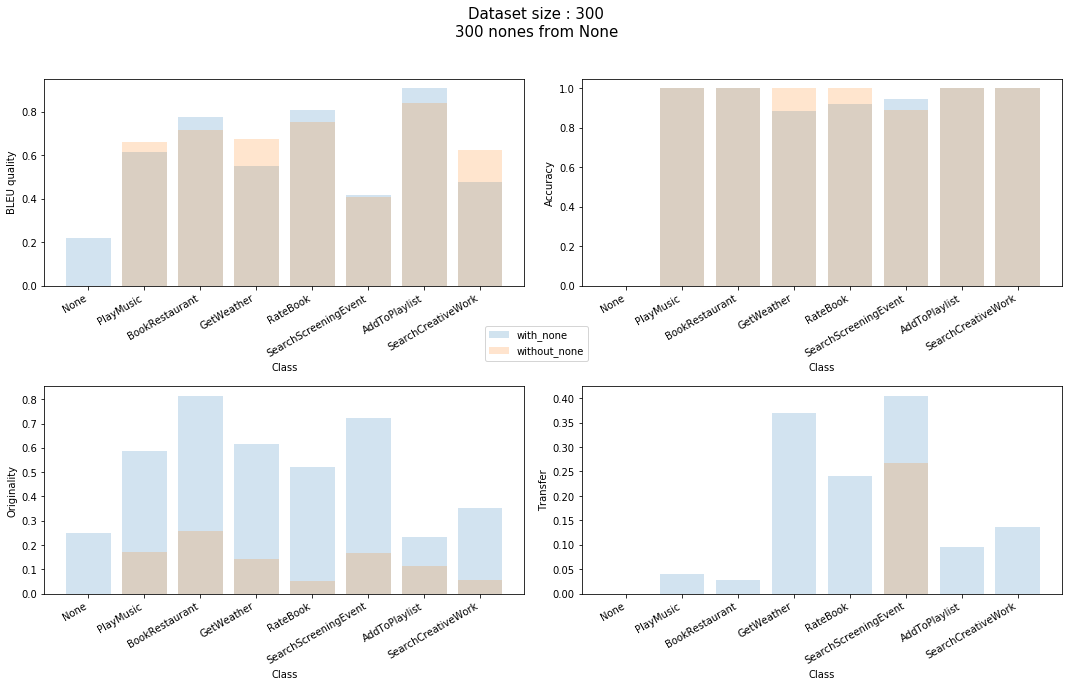

In [58]:
results_dir = 'results_semisup_assistant_general/'

with_none = torch.load(results_dir+'with_none.pkl')
without_none = torch.load(results_dir+'without_none.pkl')

fig, axarr = plt.subplots(2,2, figsize=(15,10))
axarr = axarr.flatten()

for run in [with_none, without_none]:

    bleu_qualities     = [run['delexicalised_metrics']['bleu_scores']['quality'][intent]   for intent in run['i2int']]
    bleu_diversities   = [run['delexicalised_metrics']['bleu_scores']['diversity'][intent] for intent in run['i2int']]
    originalities      = [run['delexicalised_metrics']['originality'][intent]              for intent in run['i2int']]
    transfer           = [run['delexicalised_metrics']['transfer']['metric'][intent]       for intent in run['i2int']]
    accuracies         = [run['delexicalised_metrics']['intent_accuracy'][intent]          for intent in run['i2int']]
    metrics = [bleu_qualities, accuracies, originalities, transfer]
    
    for i, metric in enumerate(metrics):
    
        axarr[i].bar([intent.split(':')[-1] for intent in run['i2int']], 
                     metric, alpha=0.2, label=run['args']['pickle'].split('/')[-1] if i==0 else '')
        for label in axarr[i].get_xmajorticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment("right")
        low, high, delta = min(metric), max(metric), max(metric) - min(metric)
        #axarr[i].set_ylim(low - 0.2 * delta, high + 0.2 * delta)
        axarr[i].set_xlabel('Class')

axarr[0].set_ylabel('BLEU quality'  )
axarr[1].set_ylabel('Accuracy'      )
axarr[2].set_ylabel('Originality'   )
axarr[3].set_ylabel('Transfer'      )

fig.suptitle('Dataset size : {}\n{} nones from {}'.format(with_none['args']['dataset_size'],
                                                                with_none['args']['none_size'], 
                                                                with_none['args']['none_intent']), fontsize=15)
fig.legend(loc='center')

fig.tight_layout(rect=[0, 0.03, 1, 0.9])

# Alpha experiment

python -m grid results_alpha "python automatic_data_generation/train_and_eval_cvae.py --dataset-size 200 --none-type snips-dump --cosine-threshold 0.95 -ep 20" --alpha:float 0 0.5 1 2 --none-size:int 200 2000 --n_parallel 3

In [107]:
from pathlib import Path
import shutil
results_dir = 'results_alpha'
runs = []

for filename in os.listdir(results_dir):
    filepath = Path(results_dir)/Path(filename)
    if filename.endswith('.pkl'):
        runs.append(torch.load(filepath))
        
runs = [run for run in runs if (run['args']['none_size']==200)]
runs = [run for run in runs if (run['args']['infersent_selection']=='unsupervised')]
runs = [run for run in runs if (run['args']['cosine_threshold']==0.)]
#runs = [run for run in runs if (run['args']['alpha']==0.5)]

runs.sort(key = lambda x : x['args']['seed'])
runs.sort(key = lambda x : x['args']['none_size'])
runs.sort(key = lambda x : x['args']['cosine_threshold'])
runs.sort(key = lambda x : x['args']['alpha'])
        
data = {}
for arg_name in runs[0]['args'].keys():
    data[arg_name] = [run['args'][arg_name] for run in runs]
data['pickle']   = np.array([run['args']['pickle'].split('/')[-1].rstrip('.pkl') for run in runs])
    
data['bleu_quality']   = np.array([run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs])
data['bleu_diversity'] = np.array([run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs])
data['accuracy']       = np.array([run['delexicalised_metrics']['intent_accuracy']['avg'] for run in runs])
data['originality']       = np.array([run['delexicalised_metrics']['originality']['avg'] for run in runs])
data['transfer']   = np.array([run['delexicalised_metrics']['transfer']['metric']['avg'] for run in runs])

data['metric'] = data['accuracy']**10 * data['originality'] #* data['bleu_quality']

df = pd.DataFrame(data, columns=['pickle', 'n_epochs', 'seed', 'dataset_size', 'none_size', 'alpha', 'cosine_threshold',
                                 'bleu_quality', 'bleu_diversity', 'accuracy', 'originality', 'transfer', 'metric'])
#df = df.sort_values(by = 'alpha', ascending=True)
print(len(runs))
df.head(1000)

16


,pickle,n_epochs,seed,dataset_size,none_size,alpha,cosine_threshold,bleu_quality,bleu_diversity,accuracy,originality,transfer,metric
0,21764,50,1,200,200,0.0,0.0,0.546448,0.210367,0.711934,0.496121,0.274684,0.016595
1,16177,50,2,200,200,0.0,0.0,0.573420,0.185868,0.744232,0.407803,0.265292,0.021259
2,34510,50,3,200,200,0.0,0.0,0.558546,0.239669,0.688841,0.445734,0.200358,0.010722
3,29375,50,1,200,200,0.1,0.0,0.579248,0.122789,0.954926,0.384896,0.111729,0.242684
4,35341,50,2,200,200,0.1,0.0,0.600207,0.107548,0.930476,0.369560,0.172801,0.179778
5,06243,50,3,200,200,0.1,0.0,0.549246,0.162951,0.921175,0.546287,0.278295,0.240350
6,14621,50,1,200,200,0.2,0.0,0.675482,0.130182,0.959263,0.230106,0.108033,0.151812
7,05292,50,1,200,200,0.5,0.0,0.652791,0.143778,0.987862,0.346277,0.079573,0.306470
8,35372,50,2,200,200,0.5,0.0,0.660854,0.138398,0.962248,0.315853,0.076575,0.214959
9,16972,50,3,200,200,0.5,0.0,0.579063,0.135645,0.987231,0.371536,0.111280,0.326730


## Averaging

In [108]:
#def allbut(df, *names):=
#    names = set(names)
#    return [item for item in df.columns if item not in names]
allbut = list(set(df.columns)-{'seed','pickle','bleu_quality','bleu_diversity','accuracy','originality','transfer','metric'})
df = df.groupby(allbut, as_index=False).mean()
df.head(20)

,n_epochs,cosine_threshold,alpha,dataset_size,none_size,seed,bleu_quality,bleu_diversity,accuracy,originality,transfer,metric
0,50,0.0,0.0,200,200,2,0.559471,0.211968,0.715002,0.449886,0.246778,0.016192
1,50,0.0,0.1,200,200,2,0.576234,0.131096,0.935526,0.433581,0.187608,0.220937
2,50,0.0,0.2,200,200,1,0.675482,0.130182,0.959263,0.230106,0.108033,0.151812
3,50,0.0,0.5,200,200,2,0.630903,0.139273,0.979114,0.344556,0.089143,0.282720
4,50,0.0,1.0,200,200,2,0.637304,0.139940,0.981502,0.306777,0.102785,0.255327
5,50,0.0,2.0,200,200,2,0.669188,0.097557,0.984062,0.321120,0.046071,0.273610


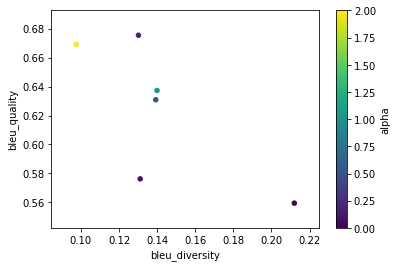

In [109]:
df.plot.scatter(x='bleu_diversity', y='bleu_quality', c='alpha', style='o', colormap='viridis', sharex=False)
plt.savefig(save_dir+'bleu_vs_bleu.png')

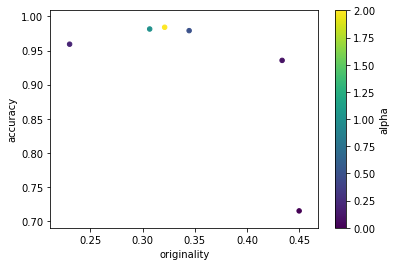

In [112]:
df.plot.scatter(x='originality', y='accuracy', c='alpha', style='o', colormap='viridis', sharex=False)
plt.savefig(save_dir+'ori_vs_acc.png')

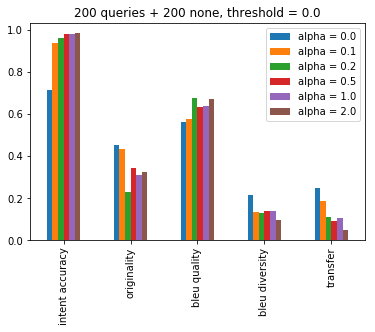

In [111]:
metric_names = ['intent accuracy', 'originality', 'bleu quality', 'bleu diversity', 'transfer']

from collections import defaultdict, OrderedDict
avg = defaultdict(list)
for run in runs:
    alpha = 'alpha = {}'.format(run['args']['alpha'])
    avg[alpha].append([run['delexicalised_metrics']['intent_accuracy']['avg'],              
                   run['delexicalised_metrics']['originality']['avg'],             
                   run['delexicalised_metrics']['bleu_scores']['quality']['avg'],  
                   run['delexicalised_metrics']['bleu_scores']['diversity']['avg'],
                   run['delexicalised_metrics']['transfer']['metric']['avg']])
for alpha, seeds in avg.items():
    avg[alpha] = np.mean(seeds, axis=0)
    
bar_df = pd.DataFrame(avg, index=metric_names)
ax = bar_df.plot.bar(rot=90)
ax.set_title('{} queries + {} none, threshold = {}'.format(runs[-1]['args']['dataset_size'], 
                                                           runs[-1]['args']['none_size'], 
                                                           runs[-1]['args']['cosine_threshold']))

plt.savefig(save_dir+'metrics.png')

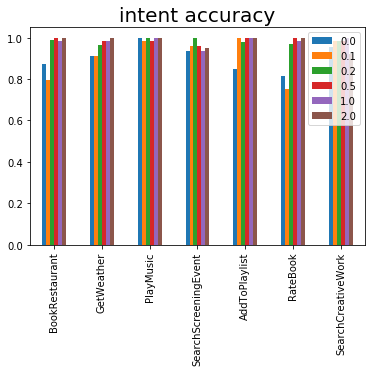

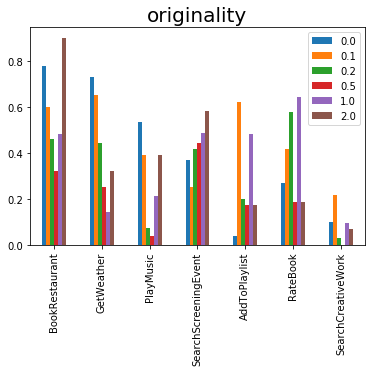

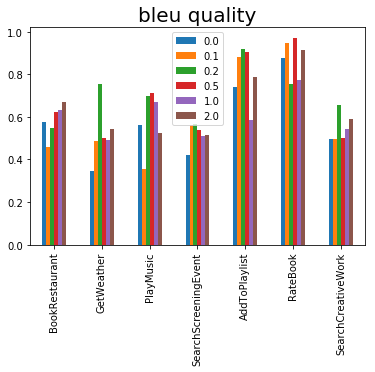

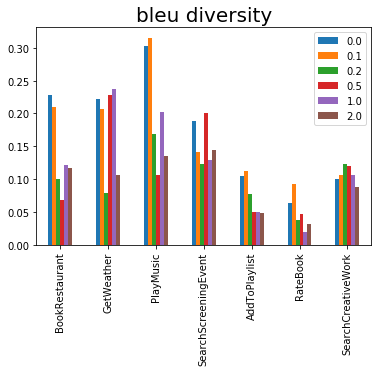

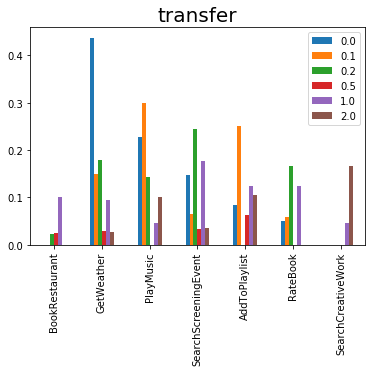

In [100]:
bleu_qualities   = []
bleu_diversities = []
originalities    = []
accuracies       = []
transfer = []

i2int = runs[-1]['i2int']
try:
    i2int.remove('None')
except:
    pass

metric_names = ['intent accuracy', 'originality', 'bleu quality', 'bleu diversity', 'transfer']
metrics = [] 

metrics.append( {run['args']['alpha'] : [run['delexicalised_metrics']['intent_accuracy'][intent]          for intent in i2int] for run in runs} )
metrics.append( {run['args']['alpha'] : [run['delexicalised_metrics']['originality'][intent]              for intent in i2int] for run in runs} )
metrics.append( {run['args']['alpha'] : [run['delexicalised_metrics']['bleu_scores']['quality'][intent]   for intent in i2int] for run in runs} )
metrics.append( {run['args']['alpha'] : [run['delexicalised_metrics']['bleu_scores']['diversity'][intent] for intent in i2int] for run in runs} )
metrics.append( {run['args']['alpha'] : [run['delexicalised_metrics']['transfer']['metric'][intent]       for intent in i2int] for run in runs} )

for metric_name, metric in zip(metric_names, metrics):
    df = pd.DataFrame(metric, index=i2int)
    ax = df.plot.bar(rot=90)
    ax.set_title(metric_name, fontsize=20)


# Baselines

In [148]:
from pathlib import Path
import shutil
results_dir = 'results_alpha'
runs = []

for filename in os.listdir(results_dir):
    filepath = Path(results_dir)/Path(filename)
    if filename.endswith('.pkl'):
        runs.append(torch.load(filepath))

baseline = [run for run in runs if (run['args']['infersent_selection'] == 'no_infersent')]

#runs = [run for run in runs if (run['args']['none_size'] in [200])]
#runs = [run for run in runs if (run['args']['seed']==1)]
runs = [run for run in runs if (run['args']['cosine_threshold'] in [0.9])]
runs = [run for run in runs if (run['args']['alpha'] in [1])]
#runs += baseline

runs.sort(key = lambda x : x['args']['seed'])
runs.sort(key = lambda x : x['args']['none_size'])
runs.sort(key = lambda x : x['args']['cosine_threshold'])
runs.sort(key = lambda x : x['args']['alpha'])
        
data = {}
for arg_name in runs[0]['args'].keys():
    data[arg_name] = [run['args'][arg_name] for run in runs]
data['pickle']   = np.array([run['args']['pickle'].split('/')[-1].rstrip('.pkl') for run in runs])
    
data['bleu_quality']   = np.array([run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs])
data['bleu_diversity'] = np.array([run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs])
data['accuracy']       = np.array([run['delexicalised_metrics']['intent_accuracy']['avg'] for run in runs])
data['originality']       = np.array([run['delexicalised_metrics']['originality']['avg'] for run in runs])
data['transfer']   = np.array([run['delexicalised_metrics']['transfer']['metric']['avg'] for run in runs])

data['metric'] = data['accuracy']**10 * data['originality'] #* data['bleu_quality']

df = pd.DataFrame(data, columns=['pickle', 'seed', 'dataset_size', 'none_size', 'alpha', 'infersent_selection', 'cosine_threshold',
                                 'bleu_quality', 'bleu_diversity', 'accuracy', 'originality', 'transfer', 'metric'])
#df = df.sort_values(by = 'alpha', ascending=True)
print(len(runs))
df.head(100)

9


,pickle,seed,dataset_size,none_size,alpha,infersent_selection,cosine_threshold,bleu_quality,bleu_diversity,accuracy,originality,transfer,metric
0,21410,1,200,0,1.0,no_infersent,0.9,0.696651,0.084594,0.982930,0.068646,0.004608,0.057788
1,25460,2,200,0,1.0,no_infersent,0.9,0.704033,0.079197,0.990024,0.049974,0.000000,0.045207
2,26690,3,200,0,1.0,no_infersent,0.9,0.660348,0.134436,0.995638,0.099105,0.000000,0.094866
3,17526,1,200,200,1.0,supervised,0.9,0.543702,0.161179,0.918632,0.262207,0.003175,0.112218
4,24944,1,200,200,1.0,unsupervised,0.9,0.706719,0.115497,0.987411,0.217756,0.024296,0.191843
5,35366,2,200,200,1.0,supervised,0.9,0.557263,0.174239,0.882314,0.126837,0.015873,0.036264
6,33678,2,200,200,1.0,unsupervised,0.9,0.653730,0.120170,0.981638,0.290575,0.062844,0.241419
7,17915,3,200,200,1.0,supervised,0.9,0.528060,0.160073,0.847732,0.262923,0.010902,0.050398
8,19568,3,200,200,1.0,unsupervised,0.9,0.600654,0.123562,0.983596,0.364057,0.101803,0.308556


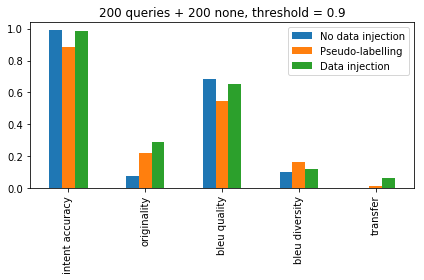

In [156]:
metric_names = ['intent accuracy', 'originality', 'bleu quality', 'bleu diversity', 'transfer']
method_names = {'no_infersent':'No data injection', 'supervised':'Pseudo-labelling', 'unsupervised':'Data injection'}

from collections import defaultdict, OrderedDict
avg = defaultdict(list)
for run in runs:
    method = method_names[run['args']['infersent_selection']]
    avg[method].append([run['delexicalised_metrics']['intent_accuracy']['avg'],              
                   run['delexicalised_metrics']['originality']['avg'],             
                   run['delexicalised_metrics']['bleu_scores']['quality']['avg'],  
                   run['delexicalised_metrics']['bleu_scores']['diversity']['avg'],
                   run['delexicalised_metrics']['transfer']['metric']['avg']])
for method, seeds in avg.items():
    avg[method] = np.mean(seeds, axis=0)
    
df = pd.DataFrame(avg, index=metric_names)
ax = df.plot.bar(rot=90)
ax.set_title('{} queries + {} none, threshold = {}'.format(runs[-1]['args']['dataset_size'], 
                                                           runs[-1]['args']['none_size'], 
                                                           runs[-1]['args']['cosine_threshold']))
plt.tight_layout()
plt.savefig(save_dir+'metrics.png')